# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1

# Data Generation

In [2]:
#Create empty graph
G = nx.Graph()

In [3]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

# Common items

In [4]:
# Runs the static black-box algorithm on subgraph G with color palette of 'level'
# Automatically updates the staticColoring variable
def staticBlackBox(g, level):
    global staticColoring
    newStaticColoring = misc.useUniquePalette(nx.coloring.greedy_color(g), level)
    staticColoring.update(newStaticColoring)
    nx.set_node_attributes(G, 0, 'recentDegree')       # Reset all recent degrees to 0

    for node in g.nodes():                             # Remove all edges adjacent to nodes in g from G'
        edges = DBB.G.edges(node)
        for edge in edges:
            DBB.removeEdge(edge[0], edge[1])
    
    levels[level] =  (set({}), levels[level][1])    # Remove all nodes from the current level node set

In [5]:
def dynamicBlackBox(s, t):
    DBB.addEdge(s, t)

In [6]:
# Resets all variables, only called during initialization and when the end of the segment at level 0 is reached
def fullReset():
    global c
    c = 0

    global maxLevel
    maxLevel = int(math.log(G.number_of_nodes(), 2))  # Calculate number of levels required, assumes number of vertices is static

    global levels
    levels = []
    for level in range(0, maxLevel+1):                
        rLevel = set({})                            # Initialize vertex sets per level for vertices with highest recent degrees
        levels.append((rLevel, True))               # Initialize all levels as active

    staticBlackBox(G, 0)                            # Color full graph using static black box with level 0 color palette



In [7]:
l = 5       # Number of updates per segment, segment length
G           # Graph to be used
staticColoring = {}

nx.set_node_attributes(G, 0, 'recentDegree')       # Reset all recent degrees to 0

Gp = nx.Graph()                     # Sparse version of graph G
Gp.add_nodes_from(G.nodes())        # Initialize with only nodes and no edges

DBB = RandomWarmUp1.WarmUp1Algo(Gp)     # Dynamic black-box algorithm to be used

fullReset()


In [8]:
# Returns a coloring dictionary by combining the two available colorings
def getColoring() -> dict:
    coloring: dict = {}
    sColoring = staticColoring
    dColoring = DBB.getColoring()

    for node in G.nodes():
        coloring[node] = (sColoring[node], dColoring[node])
    return coloring

In [9]:
# Print the current situation of the leveled segment data structure
def printLevels():
    print("l: " + str(l))
    print("c: " + str(c))

# Algorithm Specific Methods

In [10]:
# General update step called in every update
# Keeps track of the vertices with max recent degree and counter c
def updateStep():
    global c
    c = (c+1) % l
    if c == 0:

        activeLevel = 0
        for i in reversed(range(0, maxLevel+1)):    # Get active level
            if levels[i][1]:
                activeLevel = i
                break
    
        if activeLevel == 0:
            fullReset()
            print('full reeset triggered')                                                          # Run static black box on everything and reset
        else:
            staticBlackBox(G.subgraph(levels[activeLevel][0]), activeLevel)      # Run static black box on selected subgraph
            levels[activeLevel] = (levels[activeLevel][0], False)                # Deactivate this level
            for i in range(activeLevel + 1, maxLevel + 1):                       # Reactivate all levels higher than current level
                levels[i] = (levels[i][0], True)

In [11]:
5 % 3

2

In [12]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)
    if DBB.G.has_edge(s, t):
        DBB.removeEdge(s, t)
    updateStep()

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return
    G.remove_node(v)
    DBB.removeVertex(v)
    updateStep()

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return

    G.add_edge(s, t)
    DBB.G.add_edge(s, t)       # Add edge to G' directly, without running the dynamic algorithm

    # Increase recent degree of endpoints
    G.nodes[s]['recentDegree'] += 1
    G.nodes[t]['recentDegree'] += 1

    updateStep()               # Run update step in which the static algorithm is potentially ran

    if DBB.G.has_edge(s, t):    # If edge still in G' after update step, run dynamic algorithm
        DBB.removeEdge(s, t)
        dynamicBlackBox(s, t) 

    # Add node with highest recent degree to active level node sets
    if G.number_of_nodes() > 0:
        rd = -1
        n = None
        for node in G.nodes():
            if G.nodes[node]['recentDegree'] > rd:
                rd = G.nodes[node]['recentDegree']
                n = node
        for level in levels:
            if level[1]:
                level[0].add(n)

def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    staticColoring[v] = 'L0C0'
    G.nodes[v]['recentDegree'] = 0
    DBB.addVertex(v)
    updateStep()

In [33]:
getColoring()

{0: ('L0C0', 0),
 1: ('L0C2', 0),
 2: ('L0C3', 0),
 3: ('L0C1', 0),
 4: ('L0C2', 0),
 5: ('L0C0', 1),
 6: ('L0C1', 1),
 7: ('L0C0', 0),
 8: ('L0C1', 0),
 9: ('L0C2', 0),
 13: ('L0C0', 0)}

In [35]:
removeEdge(1, 3)
printLevels()
misc.draw(G, getColoring())

RuntimeError: dictionary changed size during iteration

In [15]:
matplotlib.pyplot.close()

In [16]:
for i in range (0,5):
    addVertex(13+i)

for i in range(0, 5):
    removeVertex(13+i)

In [17]:
coloring = nx.coloring.greedy_color(G)

In [18]:
coloring[0] = 0

In [19]:
coloring

{0: 0, 3: 1, 1: 2, 2: 3, 4: 2, 5: 0, 6: 1, 7: 0, 8: 1, 9: 2}

In [20]:
misc.useUniquePalette(coloring, 2)

{0: 'L2C0',
 3: 'L2C1',
 1: 'L2C2',
 2: 'L2C3',
 4: 'L2C2',
 5: 'L2C0',
 6: 'L2C1',
 7: 'L2C0',
 8: 'L2C1',
 9: 'L2C2'}

In [21]:
misc.toDrawableColoring(misc.useUniquePalette(coloring, 1))

{0: 0, 3: 1, 1: 2, 2: 3, 4: 2, 5: 0, 6: 1, 7: 0, 8: 1, 9: 2}

In [22]:
layout = nx.spring_layout(G)

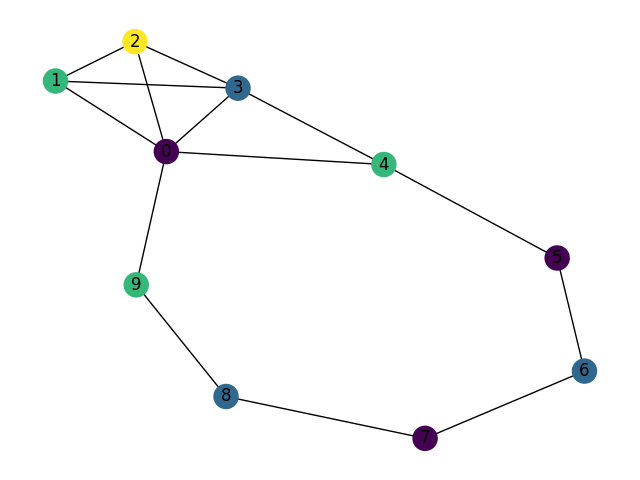

In [23]:
misc.draw(G, coloring, layout)

In [24]:
bba = SmallBucket.SmallBucketAlgo(3)

In [25]:
c1 = bba.getColoring()

bba.addEdge(3,5)

c2 = bba.getColoring()
misc.numberOfRecolors(c1, c2)

Not all nodes present in graph yet


0

In [26]:
bba.getColoring()

{}

In [27]:
bba.printBucketLevels()

|  set()  |
-----------------------------------------------
|  set()  |
-----------------------------------------------
|  set()  |
-----------------------------------------------
|  set()  |
-----------------------------------------------


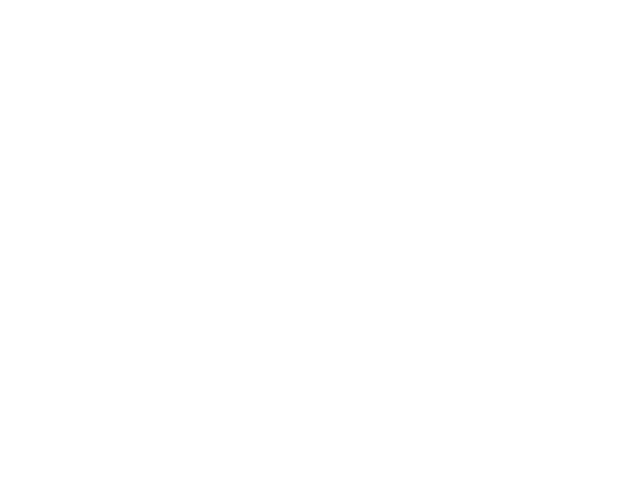

In [28]:
misc.draw(bba.G, bba.getColoring())